# Baseline - Part 1: Final Dataset Text Preprocessing & Representations 

**Environment Setup**

In [1]:
#Loading key libraries for later analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
pd.set_option('max_colwidth', 1000)
!pip install spacy
import spacy
try:
    nlp = spacy.load("en_core_web_md")
except OSError:
    import spacy.cli 
    print("Model not found. Downloading.")
    spacy.cli.download("en_core_web_md")
    import en_core_web_md
    nlp = en_core_web_md.load()
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
!pip install gensim
import gensim
from gensim.models.word2vec import Word2Vec
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV,train_test_split,StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import os
!pip install bert-serving-server 
!pip install bert-serving-client
import functions
from gensim.scripts.glove2word2vec import glove2word2vec


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.       


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

  Using cached bert_serving_client-1.10.0-py2.py3-none-any.whl (28 kB)


In [2]:
#Read in bank transactions
df = pd.read_csv(r'df_postfeat_time_series_FINAL.csv',low_memory=False,encoding='latin1')

In [3]:
#External resources
stopwords = pd.read_csv(r'stopwords.csv',low_memory=False,encoding='latin1')
abb = pd.read_csv(r'normalisation.csv',low_memory=False,encoding='latin1')

In [5]:
import os
os.getcwd()

'/project'

## 1. Text Preprocessing

### 1.1 Stopword and special character Removals

In [4]:
#Remove stopwords and special characters
functions.removals(df,stopwords,'description')
#Replace multiple spaces with single space
df.description = df.description.replace('\s+', ' ', regex=True)
#Filter out transactions that are empty after removals
df = df[df['description'] != '']

### 1.2 Text Normalisation

In [5]:
#Normalise abbrivations
functions.abbrivations(df,'description')

### 1.3 Tokenisation and Lemmatisation

In [6]:
#Tokenise and lemmatise
df['description'] = functions.tokenise_lemmatise(df,'description')

In [7]:
# Count the number of tokens of each description
df['token_length'] = [len(token) for token in df.description]
#Remove descriptions with zero tokens
df = df[df['token_length']!=0].reset_index(drop=True)

## 2. Prepare Final Dataset

In [8]:
#Replace -1 in transaction type with 0 to show the unlabelled are categroy 0
df['standard_transaction_type_id'] = df['standard_transaction_type_id'].replace(-1, 0)

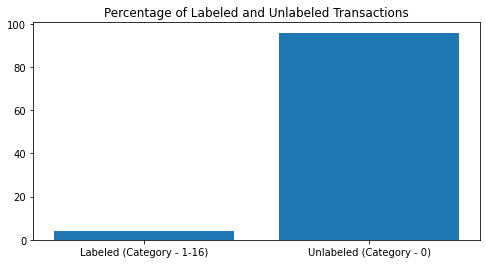

In [11]:
#Proportion of labelled and unlabelled
a1 = len(df[df['standard_transaction_type_id']!=0])/len(df)*100
a2 = len(df[df['standard_transaction_type_id']==0])/len(df)*100
X = [a1,a2]

plt.figure(figsize=(8,4))

plt.bar(range(2), X)
plt.xticks(range(2), ['Labeled (Category - 1-16)','Unlabeled (Category - 0)'])
plt.title("Percentage of Labeled and Unlabeled Transactions")
plt.savefig(r'Percentage of Labeled and Unlabeled Transactions(trad).png',bbox_inches='tight')

The number of labels by category:
1      551
2       39
3      969
4       30
5       68
6      188
7      347
8      165
9       41
10     328
11    1012
12      62
13     788
14      47
15       8
16      18
Name: standard_transaction_type_id, dtype: int64


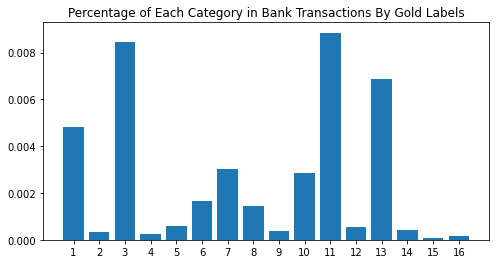

In [12]:
#Distribution of categories after labeling
print('The number of labels by category:')
print(df['standard_transaction_type_id'].value_counts().sort_index()[1:])
a1 = df['standard_transaction_type_id'].value_counts().sort_index()[1:]
X = [(x/(df['standard_transaction_type_id'].notnull().sum())) for x in a1 ]

plt.figure(figsize=(8,4))

plt.bar(range(1,17), X)
plt.xticks(range(1,17), list(range(1,17)))
plt.title("Percentage of Each Category in Bank Transactions By Gold Labels")
plt.savefig(r'Percentage of Each Category in Bank Transactions By Gold Labels.png',bbox_inches='tight')

## Final dataframe

In [9]:
#Select features for the final dataframe
final_df = df.loc[:,['local_rule_creation_date','amount', 'balance', 'description', 'debit_binary', 'foreign_binary', 'financing_binary', 'account_binary', 'hmrc_vat',
       'hmrc_corp', 'hmrc_paye','token_length','week_of_month_2','week_of_month_3','week_of_month_4','standard_transaction_type_id']]

### 2.1 Undersampling

In [13]:
#Undersample the unlabelled for give more balanced dataset
l = final_df[final_df.standard_transaction_type_id != 0]

def undersamp_per(df1,num,p):
    u = df1[df1.standard_transaction_type_id == 0].sample(round((num/(1-p))*p),random_state=42)
    f_p = pd.concat([l,u])
    return f_p

#Undersample to a ratio of 60:40: total unlabelled to total labelled transactions
df_4 = undersamp_per(final_df,len(l),0.4)

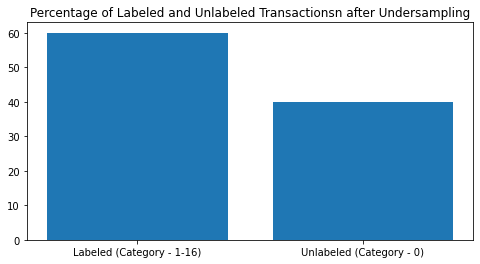

In [12]:
#Distribution of labelled and unlabelled in the final dataframe
a1 = len(df_4[df_4['standard_transaction_type_id']!=0])/len(df_4)*100
a2 = len(df_4[df_4['standard_transaction_type_id']==0])/len(df_4)*100
X = [a1,a2]

plt.figure(figsize=(8,4))

plt.bar(range(2), X)
plt.xticks(range(2), ['Labeled (Category - 1-16)','Unlabeled (Category - 0)'])
plt.title("Percentage of Labeled and Unlabeled Transactionsn after Undersampling")
plt.savefig(r'L U ratio after undersampling（trad).png',bbox_inches='tight')

The number of labels by category:
0     3107
1      551
2       39
3      969
4       30
5       68
6      188
7      347
8      165
9       41
10     328
11    1012
12      62
13     788
14      47
15       8
16      18
Name: standard_transaction_type_id, dtype: int64


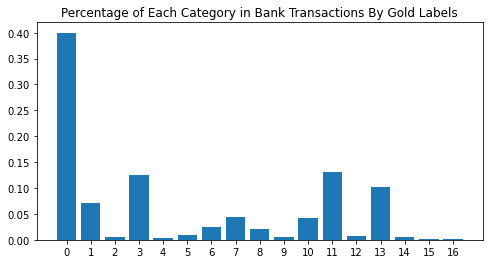

In [14]:
#Distribution of categories in the final dataset
print('The number of labels by category:')
print(df_4['standard_transaction_type_id'].value_counts().sort_index())
a1 = df_4['standard_transaction_type_id'].value_counts().sort_index()
X = [(x/(df_4['standard_transaction_type_id'].notnull().sum())) for x in a1 ]

plt.figure(figsize=(8,4))

plt.bar(range(17), X)
plt.xticks(range(17), list(range(17)))
plt.title("Percentage of Each Category in Bank Transactions By Gold Labels")
plt.savefig(r'Percentage of Each Category in Bank Transactions By Gold Labels.png',bbox_inches='tight')

### 2.2 Train Test Split

In [24]:
#Getting X, y datasets
X = df_4.iloc[:,:-1]
y = df_4.iloc[:,-1]

In [19]:
#Split training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
#Get their indices for later usage
train_indices = X_train.index
test_indices = X_test.index

## 3. Word Representation

In [21]:
#Joining the transaction descriptions to a list
X_train_des = [' '.join(x) for x in X_train['description']]

### 3.1 Frequency-based Methods

In [22]:
svc = SVC(random_state=200)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=200)

def count_vect(df,x):
    ngram = list()
    for n in range(1,6):
        if x >0 :
            bow =  CountVectorizer(ngram_range=(1,n))
            tfidf=  TfidfVectorizer(ngram_range=(1,n))
            i = (1,n)
        else:
            bow =  CountVectorizer(ngram_range=(n,n))
            tfidf=  TfidfVectorizer(ngram_range=(n,n))
            i = (n,n)
            
        tfidf_matrix = tfidf.fit_transform(df)
        bow_matrix = bow.fit_transform(df)
        tfidf_cv = cross_val_score(svc, tfidf_matrix, y_train, cv=kfold, scoring='f1_macro').mean()
        bow_cv = cross_val_score(svc, bow_matrix, y_train, cv=kfold, scoring='f1_macro').mean()
        print('n-gram :{}, Bag of Words F1 Score: {},TF-iDF F1 Score: {} '.format(i,bow_cv,tfidf_cv))
        ngram.append({'n': n, 'score': tfidf_cv, 'type': 'TF-iDF'})
        ngram.append({'n': n, 'score': bow_cv, 'type': 'Bag of Words'})
    return pd.DataFrame(ngram)

In [65]:
#Check the F1 score of single n-grams
n_gram_1 = count_vect(X_train_des,0)

n-gram :(1, 1), Bag of Words F1 Score: 0.8921482580555153,TF-iDF F1 Score: 0.8833552878080442 
n-gram :(2, 2), Bag of Words F1 Score: 0.8602096201501341,TF-iDF F1 Score: 0.8596511459533449 
n-gram :(3, 3), Bag of Words F1 Score: 0.6742389907364899,TF-iDF F1 Score: 0.6742114062632657 
n-gram :(4, 4), Bag of Words F1 Score: 0.5097769695296124,TF-iDF F1 Score: 0.5148276162064283 
n-gram :(5, 5), Bag of Words F1 Score: 0.4182962900232955,TF-iDF F1 Score: 0.43840586636810625 


In [23]:
#Check the F1 score of mixed n-grams
n_gram_2 = count_vect(X_train_des,1)

n-gram :(1, 1), Bag of Words F1 Score: 0.8921482580555153,TF-iDF F1 Score: 0.8833552878080442 
n-gram :(1, 2), Bag of Words F1 Score: 0.8925714559448636,TF-iDF F1 Score: 0.8865070130000132 
n-gram :(1, 3), Bag of Words F1 Score: 0.8947866371942694,TF-iDF F1 Score: 0.8845653070865144 
n-gram :(1, 4), Bag of Words F1 Score: 0.891561576817859,TF-iDF F1 Score: 0.8855271318258533 
n-gram :(1, 5), Bag of Words F1 Score: 0.8886670217159681,TF-iDF F1 Score: 0.8847048858705454 


In [71]:
#Plot n-gram results
def plot_count(df):
    plt.figure(figsize=(10,4))
    a= df[df['type']=='Bag of Words']
    b= df[df['type']=='TF-iDF']

    #Plot line graphs
    plt.plot(a['n'], a['score'], label= "Bag of Words",color='steelblue',linewidth=3)
    plt.plot(b['n'], b['score'], label="TF-IDF",color='skyblue',linewidth=3)

    #Format plot
    plt.xlabel('n-grams')
    plt.ylabel('F1 Score')
    plt.title("BoW and TF-iDF Performance by n-gram values")
    plt.legend()
    plt.show()

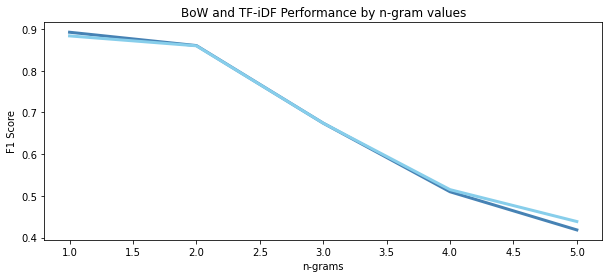

In [88]:
#Plot of single n-grams
plot_count(n_gram_1)

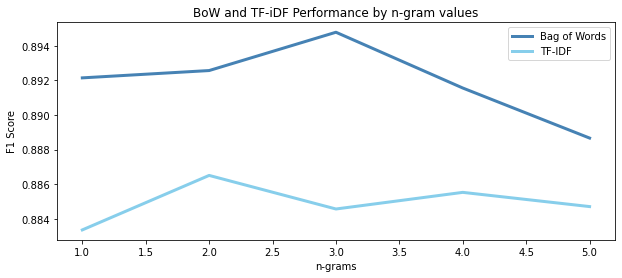

In [72]:
#Plot of mixed n-grams
plot_count(n_gram_2)

In [45]:
svc = SVC(random_state=200)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=200)

#Getting the maximum number of features for the optimal model
def max_feat(index,model,model_name):
    vec =  model(ngram_range=index)
    vec_matrix = vec.fit_transform(X_train_des)
    a = vec_matrix.shape
    
    vec_result = list()
    for n in range(100, a[1], 1000):
        vec = model(ngram_range=index,max_features=n)
        vec_matrix = vec.fit_transform(X_train_des)
        score_countVec = cross_val_score(svc, vec_matrix, y_train, cv=kfold, scoring='f1_macro').mean()

        vec_result.append({'max_feature': n,  'score': score_countVec})
    print('finished')
    
    vec_result_df = pd.DataFrame(vec_result)
    plt.figure(figsize=(10,4))
    #Plot line graphs
    plt.plot(vec_result_df['max_feature'], vec_result_df['score'],color='steelblue',linewidth=3)
    #Format plot
    plt.xlabel('Number of features')
    plt.ylabel('F1 Score')
    plt.title("Maximum Number of Features in {}".format(model_name))
    plt.show()
    
    max_score = vec_result_df['score'].max()
    a = vec_result_df[vec_result_df['score'] == max_score]
    a = a.iloc[0]['max_feature']
    print('maximum feature is {}'.format(a))

finished


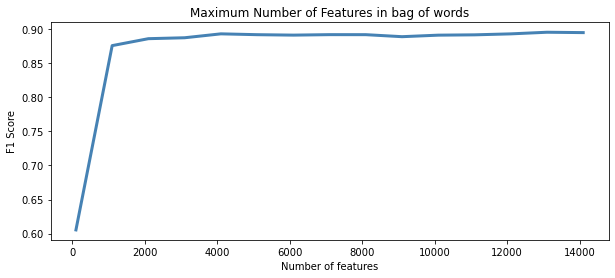

maxiumn feature is 13100.0


In [46]:
#Optimal number of features of Countvectoriser
max_feat((1,3),CountVectorizer,'bag of words')

In [58]:
#Getting the word representation from bag of words for later comparison
bow = CountVectorizer(ngram_range=(1,3),max_features=13100,min_df=2)
bow_matrix = bow.fit_transform(X_train_des)

### 3.2 Prediction-based Methods

**3.2.1 Word2vec: Self-trained**

In [29]:
#Turn description to list to feed into word2vec
X_train_list = X_train['description'].tolist()

In [30]:
#feed to model
word2vec_self_model = Word2Vec(X_train_list, size=300, window=5, min_count=2, iter=100)

#save the model
word2vec_self_model.save(r'word2vec_self.w2v')
word2vec_self_model.wv.save_word2vec_format(r'word2vec_self.bin',binary=False)

#reload the model to reduce training time
word2vec_self = word2vec_self_model.wv.load_word2vec_format(r'word2vec_self.bin',binary=False)

In [31]:
def w2v_vectorise(texts, word2vec_model):
        i = 0
        index2word_set = set(word2vec_model.index2word)
        description_vector = np.zeros((word2vec_model.vector_size))
        for text in texts:
                if text in index2word_set:
                        description_vector = np.add(description_vector, word2vec_model[text])
                        i += 1
        text_vector = np.divide(description_vector, i)
        return text_vector

#Generate the Word2Vec model
startTime = time.time()
vector_list = []
i = 0
for texts in X_train_list:
        i += 1
        if i % 3000 == 0: 
                print('%.2fs used for generating word embeddings for top %d transaction description' %(time.time()-startTime,i))
        vector_list.append(w2v_vectorise(texts, word2vec_self) )
        word2vec_self_matrix= np.array(vector_list)
        
print('Total time used:%.2fs' % (time.time() - startTime) )

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


3.14s used for generating word embeddings for top 3000 transaction description
13.47s used for generating word embeddings for top 6000 transaction description
Total time used:14.51s


In [32]:
#Get the word2vec matrix for comparison
word2vec_self_matrix[np.isnan(word2vec_self_matrix)] = 0
word2vec_self_matrix = pd.DataFrame(word2vec_self_matrix)

**3.2.2 Word2vec: Google news pre-trainedd**

In [33]:
#Load pretrained model
word2vec_pre_model = gensim.models.KeyedVectors.load_word2vec_format(r'GoogleNews-vectors-negative300.bin.gz', binary=True)  
word2vec_pre_model.vector_size

300

In [34]:
#Check out of vocabulary words
def oov(texts, model, check_function):
    exist_total = 0
    total = 0
    total_word_set = set()
    oov_set = set()
    for line in texts:
        for text in line :
            total +=1
            total_word_set.add(text)
            if check_function(model, text):
                exist_total +=1

    for text in total_word_set:
        if check_function(model, text):
            pass
        else:
            oov_set.add(text)
    
    distinct_oov = round(len(oov_set)/len(total_word_set), 4)
    total_oov = round(1 - exist_total/total, 4)
    print('Percentage of distinct out of vocabulary words: {:.2f}%'.format(distinct_oov*100))
    print('Total percentage of out of vocabulary words in the word set: {:.2f}%'.format(total_oov*100))
    print(oov_set)
    return distinct_oov, total_oov, oov_set

#Change the form of words to check whether it is oov
def w2v_check(model, text):
    return (text in model.vocab) or (text.upper() in model.vocab)or (text.capitalize() in model.vocab)

distinct_oov, total_oov, oov_set = oov(X_train['description'], word2vec_pre_model, w2v_check)

Percentage of distinct out of vocabulary words: 23.49%
Total percentage of out of vocabulary words in the word set: 9.70%
{'atkar', 'chouchou', 'systemindigo', 'gamemine', 'yjl', 'bnlkbmw', 'quvhnmqv', 'uverjyb', 'rtsnutrition', 'shlvng', 'faltec', 'smjupgn', 'refresment', 'ipok', 'trnsfer', 'storescard', 'trceo', 'ckpu', 'juosr', 'bkcgnrs', 'fourthbrighton', 'tackfield', 'vrzdagocardless', 'sawcentrelt', 'nndr', 'ltchelmsford', 'nagement', 'shreena', 'hubx', 'zwv', 'townandcountryfine', 'customersure', 'yuzt', 'kydmval', 'softwarnm', 'pymtbfp', 'fsprg', 'kflfj', 'rbsdm', 'osbs', 'soben', 'nutrience', 'janlkllb', 'wework', 'ykpqb', 'loquet', 'busisee', 'mainv', 'oibrhhc', 'directcard', 'earlymorningmedia', 'leasin', 'accrec', 'payetravel', 'streetstratford', 'constru', 'xbiteltd', 'centp', 'ppxr', 'ricohcapital', 'jamroxs', 'xoesyepx', 'chawanzwa', 'financrbs', 'orbtalk', 'gdmuteyn', 'bbfccyc', 'sacard', 'finalta', 'kpwd', 'mbmcn', 'honr', 'optiv', 'kareplusmk', 'bicard', 'marketg', 'c

In [35]:
#Give pre-train Word2Vec embeddings
def w2v_embeddings(model, texts):
        matrix =[]
        for text in texts:
            oov_matrix = []
            if len(text) > 0 :
                for word in text:
                    if  word in model.vocab:
                        oov_matrix.append(model[word])
                    elif word.upper() in model.vocab:
                        oov_matrix.append(model[word.upper()])
                    elif word.capitalize() in model.vocab:
                        oov_matrix.append(model[word.capitalize()])

            if len(oov_matrix) == 0:
                oov_matrix.append(np.zeros(model.vector_size))
            matrix.append(np.mean(oov_matrix, axis=0))
        return matrix

#Get the embedding matrix
w2v_pre_model = w2v_embeddings(word2vec_pre_model,np.array(X_train['description']))
w2v_pre_model_df = pd.DataFrame(w2v_pre_model)

#### 3.2.3 GloVe: Pre-trained 300D

In [37]:
#Get the pretrained model
word2vec_output_file = r'glove.840B.300d.word2vec.txt'
#load the model
glove = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [38]:
def glov_check(model, text):
    return text in model

#Checking OOV in GloVe
distinct_oov, total_oov, oob_words = oov(X_train['description'], glove, glov_check)

Percentage of distinct out of vocabulary words: 29.44%
Total percentage of out of vocabulary words in the word set: 11.11%
{'atkar', 'systemindigo', 'gamemine', 'yjl', 'uverjyb', 'bnlkbmw', 'quvhnmqv', 'madine', 'printerland', 'rtsnutrition', 'shlvng', 'faltec', 'smjupgn', 'tsba', 'ipok', 'trnsfer', 'refresment', 'storescard', 'scyl', 'trceo', 'ckpu', 'juosr', 'bkcgnrs', 'fourthbrighton', 'tackfield', 'vrzdagocardless', 'sawcentrelt', 'nndr', 'townfield', 'ltchelmsford', 'shreena', 'axh', 'hubx', 'zwv', 'townandcountryfine', 'customersure', 'yuzt', 'kydmval', 'softwarnm', 'pymtbfp', 'fsprg', 'kflfj', 'moorhouse', 'rbsdm', 'hywel', 'osbs', 'soben', 'vhl', 'nutrience', 'hillen', 'irelan', 'intercargo', 'janlkllb', 'wework', 'ykpqb', 'loquet', 'busisee', 'moufb', 'shefford', 'odedra', 'datamatics', 'mainv', 'royton', 'oibrhhc', 'hodd', 'directcard', 'earlymorningmedia', 'leasin', 'accrec', 'payetravel', 'hyten', 'streetstratford', 'xbiteltd', 'centp', 'ppxr', 'ricohcapital', 'jamroxs', 'x

In [39]:
#Get glove embeddings for transaction description
def glov_embeddings(model, texts):
        matrix =[]
        for text in texts:
            oov_matrix = []
            if len(text) > 0 :
                for word in text:
                    if  word in model.vocab:
                        oov_matrix.append(model[word])

            if len(oov_matrix) == 0:
                oov_matrix.append(np.zeros(model.vector_size))
            matrix.append(np.mean(oov_matrix, axis=0))
        return matrix

glove_pre_model_ = glov_embeddings(glove,np.array(X_train['description']))
glove_pre_df = pd.DataFrame(glove_pre_model_)

**3.2.4 BERT**

In [37]:
#Load BERT
from bert_serving.client import BertClient
bc = BertClient()

In [38]:
#Get BERT representations
bert_embed = bc.encode(X_train_des)

### 3.3 Word Representation Selection

In [40]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=200)

#Get the crossvalidation F1 score of the representations
score_w2v_self = cross_val_score(svc, word2vec_self_matrix, y_train, cv=kfold, scoring='f1_macro')
score_w2v_pre_train = cross_val_score(svc, w2v_pre_model_df, y_train, cv=kfold, scoring='f1_macro')
score_bow = cross_val_score(svc, bow_matrix, y_train,cv=kfold, scoring='f1_macro')
score_glov = cross_val_score(svc, glove_pre_df, y_train, cv=kfold, scoring='f1_macro')
score_bert = cross_val_score(svc, bert_embed, y_train, cv=kfold, scoring='f1_macro')
print(score_bow.mean())
print(score_w2v_self.mean())
print(score_w2v_pre_train.mean())
print(score_glov.mean())
print(score_bert.mean())

0.8950891583330879
0.7467305160166757
0.8139457204697054
0.8016367196380949
0.6448047049602799


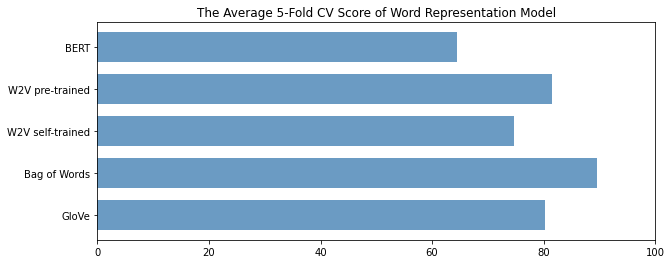

In [41]:
plt.figure(figsize=(10,4))

# Plot the score of each model
plt.barh(range(5), [score_glov.mean()*100,score_bow.mean()*100,score_w2v_self.mean()*100,score_w2v_pre_train.mean()*100,score_bert.mean()*100], height=0.7, color='steelblue', alpha=0.8)
plt.yticks(range(5), ['GloVe','Bag of Words','W2V self-trained', 'W2V pre-trained','BERT'])
plt.xlim(0,100)
plt.title("The Average 5-Fold CV Score of Word Representation Model")
plt.savefig(r'CV Score of Word Representation Model"(after semi).png',bbox_inches='tight')

In [42]:
scoring = ('accuracy','precision_macro','recall_macro','f1_macro')
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=200)

#Getting a set of scores of word representations
score_bow = cross_validate(svc, bow_matrix, y_train, cv=kfold, scoring= scoring,n_jobs = -1)
score_w2v_self = cross_validate(svc, word2vec_self_matrix, y_train, cv=kfold, scoring= scoring,n_jobs = -1)
score_w2v_pre_train = cross_validate(svc, w2v_pre_model_df, y_train, cv=kfold, scoring= scoring,n_jobs = -1)
score_glov = cross_validate(svc, glove_pre_df, y_train, cv=kfold, scoring= scoring,n_jobs = -1)
score_bert = cross_validate(svc, bert_embed, y_train, cv=kfold, scoring= scoring,n_jobs = -1)

In [43]:
#Show the scores
results = list()
scores = [score_bow,score_w2v_self,score_w2v_pre_train,score_glov,score_bert]

for score in scores:
    sorted(score.keys())
    accuracy = score['test_accuracy'].mean()
    precision_macro = score['test_precision_macro'].mean()
    recall_macro = score['test_recall_macro'].mean()
    f1_macro = score['test_f1_macro'].mean()
    print('Accuracy: {},Precision: {},Recall: {},F1 Score: {}'.format(accuracy,precision_macro,recall_macro,f1_macro))
    results.append({'accuracy':accuracy ,'precision':precision_macro, 'recall':recall_macro ,'f1_score':f1_macro})

Accuracy: 0.9336978869106611,Precision: 0.9496038928053074,Recall: 0.8702767989635062,F1 Score: 0.8950891583330879
Accuracy: 0.8913753412021975,Precision: 0.8118307397971755,Recall: 0.7249596526311277,F1 Score: 0.7467305160166757
Accuracy: 0.9113292732376994,Precision: 0.8568632886412567,Recall: 0.794769310481916,F1 Score: 0.8139457204697054
Accuracy: 0.8979733204819776,Precision: 0.8526908617434742,Recall: 0.7819768198577572,F1 Score: 0.8016367196380949
Accuracy: 0.8731906729213386,Precision: 0.7357895391825227,Recall: 0.6074938256829434,F1 Score: 0.6448047049602799


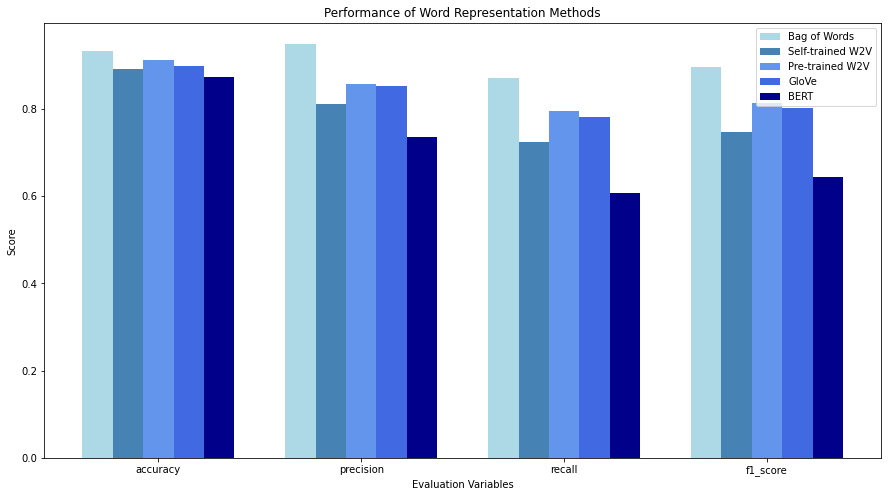

In [44]:
a = pd.DataFrame(results)
model = ['Bag of Words','Self-trained W2V','Pre-trained W2V','GloVe','BERT']
fig, ax = plt.subplots(figsize=(15,8))

# Plot the score of each model
X = np.arange(4)
plt.bar(X + 0.00, a.loc[0], color = 'lightblue', width = 0.15,label=model[0])
plt.bar(X + 0.15, a.loc[1], color = 'steelblue', width = 0.15,label=model[1])
plt.bar(X + 0.30, a.loc[2], color = 'cornflowerblue', width = 0.15,label=model[2])
plt.bar(X + 0.45, a.loc[3], color = 'royalblue', width = 0.15,label=model[3])
plt.bar(X + 0.60, a.loc[4], color = 'darkblue', width = 0.15,label=model[4])

ax.set_xticks([0.3,1.3,2.3,3.3])
ax.set_xticklabels(a.columns)
plt.xlabel('Evaluation Variables')
plt.ylabel('Score')
plt.title("Performance of Word Representation Methods")
plt.legend()

plt.savefig(r'Performance of Word Representation Methods.png',bbox_inches='tight')

## 4. Generate Text Feature for the Final DataFrame

In [26]:
#Get the embedding for the final representation: bag of words
bow = CountVectorizer(ngram_range=(1,3),max_features=13100)
bow_matrix = bow.fit_transform(X_train_des)

def bow_vectoriser(df,indices):
    des = [' '.join(x) for x in df['description']]
    bow_trans = bow.transform(des)
    bow_df = bow_trans.toarray()
    bow_df = pd.DataFrame(bow_df)
    bow_df.index = indices
    return bow_df

X_train_des = bow_vectoriser(X_train,train_indices)
X_test_des = bow_vectoriser(X_test,test_indices)

In [31]:
#Form the final training and testing sets
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

def form_final_df(des_df,num_df,label):
    num_df['amount_std'] = scaler.fit_transform(num_df['amount'].values.reshape(-1,1))
    num_df['balance_std'] = scaler.fit_transform(num_df['balance'].values.reshape(-1,1))
    X = pd.concat([des_df,num_df[['local_rule_creation_date','amount_std','balance_std','debit_binary', 'foreign_binary','financing_binary','account_binary','hmrc_vat','hmrc_corp','hmrc_paye','week_of_month_2','week_of_month_3','week_of_month_4','token_length']]], axis=1)
    X_withlabels = pd.concat([X,label], axis=1)
    return X_withlabels

Train = form_final_df(X_train_des,X_train,y_train)
Test = form_final_df(X_test_des,X_test,y_test)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [34]:
Train.to_csv(r'Train_trad.csv')
Test.to_csv(r'Test_trad.csv')